In [ ]:
%matplotlib notebook
import torch
import matplotlib.pyplot as plt
import schemes as sc

# Data type and device setup

In [2]:
dtype = torch.float
device = torch.device("cpu")

# Generate signal

<IPython.core.display.Javascript object>


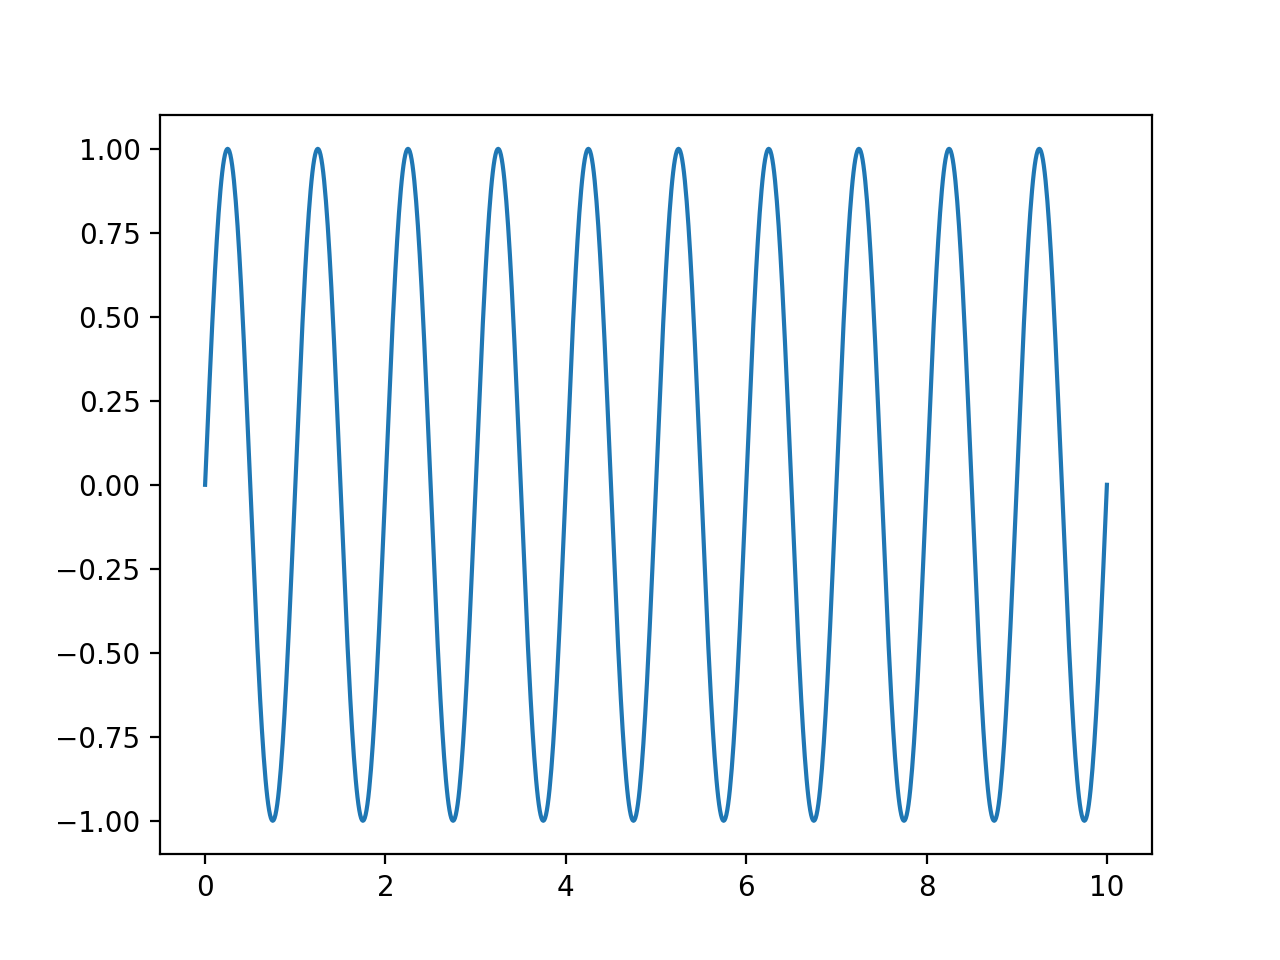

In [3]:
freq = 1
t_true = torch.linspace(0, 10, 1001)
x_true = torch.sin(2 * torch.pi * freq * t_true)

fig = plt.figure()
axs = fig.add_subplot(1, 1, 1)
axs.plot(t_true, x_true)
#plt.show()

In [4]:
dt = t_true[1] - t_true[0]
Nc = 100

<img src="./Figures/Model_1.png" alt="Model Outline" width="1000" height="1000">

# Model 

In [5]:
def model(t, xx, w0):
    return torch.mm(xx, w0)

# Initialization

In [6]:
τ = torch.tensor([0.2], device=device, dtype=dtype, requires_grad=True)
w0 = torch.zeros((2, 2), device=device, dtype=dtype, requires_grad=True)

lr_tau = 1e-4
lr_w0 = 1
batch_size = 20
batch_time = 10  # (x_true)-Nc
lr_pow_w0 = torch.linspace(0, -2, 100)
lr_pow_tau = torch.linspace(0, -4, 100)

loss_arr   = []
τ_arr      = []
τ_grad_arr = []

<IPython.core.display.Javascript object>


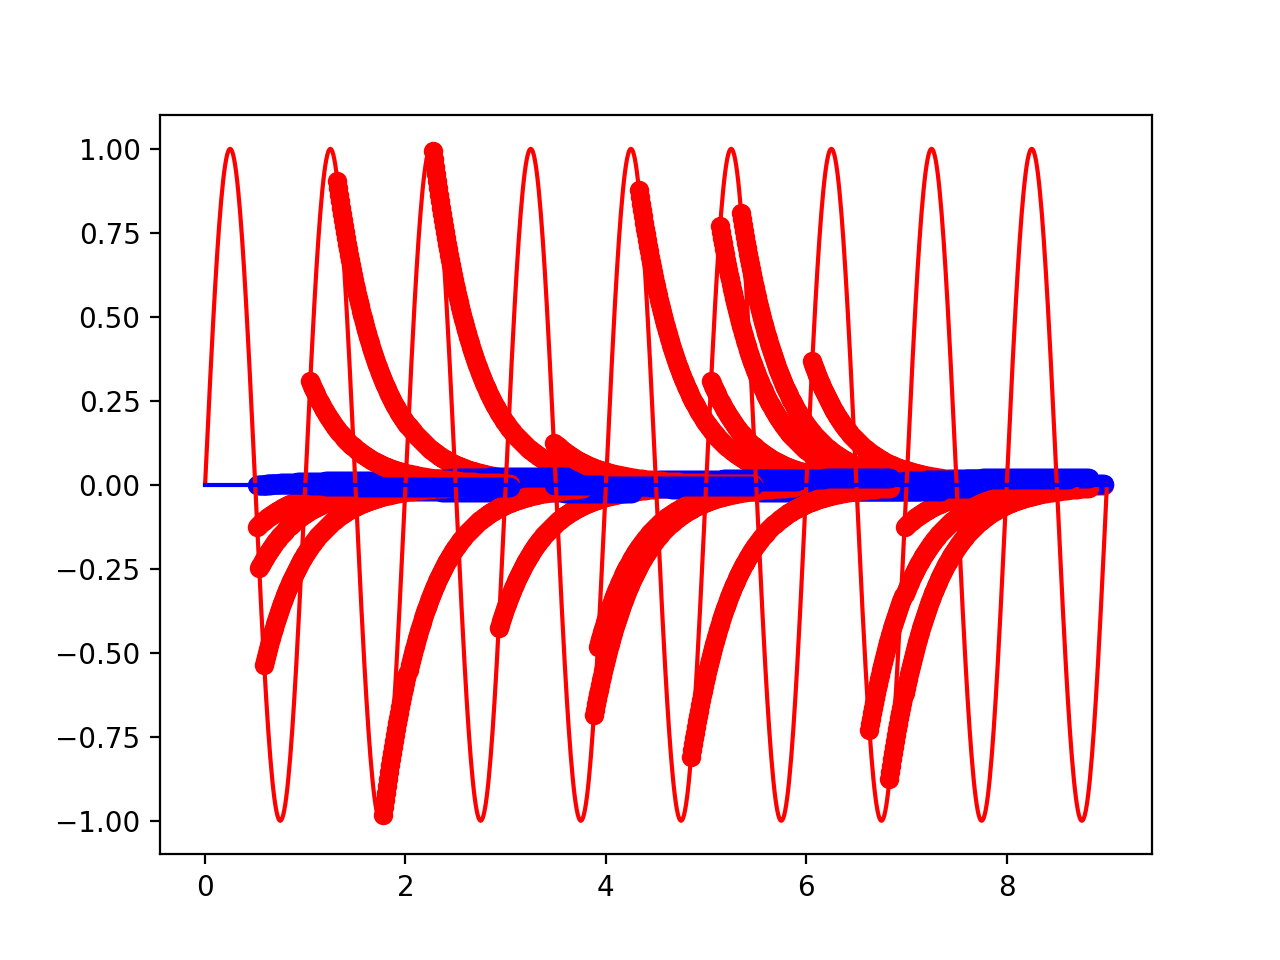

lr_w0= 1
batch_time= 10
Cleared figure.
iter= 0
loss= 0.1761114
w0= [[ 0.00150385 -0.01530317]
 [ 0.01360708 -0.00671071]]
tau= [0.2]
Cleared figure.
Cleared figure.
iter= 25
loss= 0.18564703
w0= [[-0.00589557 -0.12568596]
 [ 0.07700045 -0.01026748]]
tau= [0.2]
Cleared figure.
Cleared figure.
Cleared figure.
iter= 50
loss= 0.1778616
w0= [[-0.01180571 -0.24257915]
 [ 0.13864163  0.00395584]]
tau= [0.2]
Cleared figure.
Cleared figure.
iter= 75
loss= 0.17930016
w0= [[-0.00041235 -0.34593752]
 [ 0.21690726  0.00078679]]
tau= [0.2]
Cleared figure.
Cleared figure.
lr_w0= 1
batch_time= 20
Cleared figure.
iter= 100
loss= 0.34515667
w0= [[ 0.00800115 -0.4675079 ]
 [ 0.3047237  -0.01909652]]
tau= [0.2]
Cleared figure.
Cleared figure.
iter= 125
loss= 0.34892628
w0= [[-0.09456145 -0.98328733]
 [ 0.6226994  -0.01949313]]
tau= [0.2]
Cleared figure.
Cleared figure.
Cleared figure.
iter= 150
loss= 0.32215983
w0= [[-0.03456726 -1.4799439 ]
 [ 1.0102426  -0.0188112 ]]
tau= [0.2]
Cleared figure.
Cleared 

Cleared figure.
Cleared figure.
lr_w0= 1
batch_time= 150
Cleared figure.
iter= 1400
loss= 0.39611262
w0= [[-2.9936852  -0.0777939 ]
 [ 4.360805   -0.01514249]]
tau= [-0.00055036]
Cleared figure.
Cleared figure.
iter= 1425
loss= 0.39348477
w0= [[-2.9290624  -0.04890786]
 [ 4.1115336  -0.00422369]]
tau= [-0.00055036]
Cleared figure.
Cleared figure.
Cleared figure.
iter= 1450
loss= 0.3800878
w0= [[-2.8783462e+00 -5.9407435e-02]
 [ 3.8618941e+00  2.9676352e-03]]
tau= [-0.00055036]
Cleared figure.
Cleared figure.
iter= 1475
loss= 0.38702163
w0= [[-2.8216295  -0.05807716]
 [ 3.6115675  -0.01061265]]
tau= [-0.00055036]
Cleared figure.
Cleared figure.
lr_w0= 1
batch_time= 160
Cleared figure.
iter= 1500
loss= 0.38620743
w0= [[-2.780811   -0.03927901]
 [ 3.3613584  -0.0074549 ]]
tau= [-0.00055036]
Cleared figure.
Cleared figure.
iter= 1525
loss= 0.3697833
w0= [[-2.7220643e+00  4.2157710e-02]
 [ 3.1132224e+00 -2.5972994e-03]]
tau= [-0.00055036]
Cleared figure.
Cleared figure.
Cleared figure.
iter

In [7]:
fig = plt.figure()
axs = fig.add_subplot(1, 1, 1)
for kk in range(2000):

    # lr_w0 = 1e-4 + 1e-1 * torch.tanh(torch.tensor(kk/500))
    # lr_tau = 1e-1 * torch.tensor(10).pow(lr_pow_tau[kk//100])
    batch_time = 10 + ((kk // 100) * 10);

    if kk % 100 == 0:
        print('lr_w0=', lr_w0)
        print('batch_time=', batch_time)

    z_true = sc.interp_linear(t_true,x_true,Nc,τ)

    if kk % 100 == 0:
        st_id = torch.randint(0, len(z_true) - batch_time, (1,)).item()

    id_sel = torch.randint(0, z_true.shape[0] - batch_time, (batch_size,))
    z_true_stack = torch.stack([z_true[id_sel + i, :] for i in range(batch_time)], dim=0)
    t_true_stack = torch.stack([t_true[id_sel + i] for i in range(batch_time)], dim=0)
    # print(z_true_stack.shape)
    # print(t_true_stack.shape)

    for i in range(0, batch_time):
        fun = lambda t, x: model(t, x, w0)
        if i == 0:
            z_pred = z_true_stack[i, :, :].reshape(1, z_true_stack.shape[1], z_true_stack.shape[2])
        else:
            z_next = sc.rk4(fun, t_true[i], z_pred[i - 1, :, :], dt)
            z_pred = torch.cat([z_pred, z_next.reshape(1, z_true_stack.shape[1], z_true_stack.shape[2])], 0)

    # print("z_pred.shape=", z_pred.shape)
    # print("z_true.shape=",z_true[0:batch_time,:].shape)
    # loss = torch.abs((z_true[0:batch_time,:]-z_pred)).sum() + torch.abs(w0).sum()

    # loss = (z_true_stack-z_pred).pow(2).mean() #+ 1e-5* torch.abs(w0).sum()
    loss = torch.abs((z_true_stack - z_pred)).mean() + 1e-2 * torch.abs(w0).sum()
    loss.backward()

    with torch.no_grad():
        w0_old = w0.detach().numpy()
        τ_old = τ.detach().numpy()

        # print(τ_old)
        τ_arr.append(τ_old)
        τ_grad_arr.append(τ.grad.detach().numpy())
        # print(w0.grad)
        w0 -= lr_w0 * w0.grad
        if kk > 300:
            τ -= lr_tau * τ.grad * (10 * (kk % 10 == 0) + (kk % 10 != 0))

        loss_arr.append(loss.item())
        # print(loss.item())
        if kk % 10 == 0:
            # Visualize
            plt.cla()
            print("Cleared figure.")
            for p_id in range(batch_size):
                axs.plot(t_true_stack.detach().numpy()[:, p_id], z_pred[:, p_id, 0].detach().numpy(), 'ro')
                axs.plot(t_true_stack.detach().numpy()[:, p_id], z_pred[:, p_id, 1].detach().numpy(), 'bo')

            axs.plot(t_true[0:len(z_true)], z_true[:, 0].detach().numpy(), 'r-')
            axs.plot(t_true[0:len(z_true)], z_true[:, 1].detach().numpy(), 'b-')
            
            plt.show(block=False)

            fig.canvas.draw()
            plt.pause(0.0001)

        if kk % 25 == 0:
            print("iter=", kk)
            print("loss=", loss.detach().numpy())
            print("w0=", w0.detach().numpy())
            print("tau=", τ.detach().numpy())

        w0.grad = None
        τ.grad = None